# Exponential Smoothing for Time Series Forecasting

This notebook demonstrates how to apply exponential smoothing techniques to renewable and non-renewable energy production time series data. Exponential smoothing is a powerful forecasting method that gives more weight to recent observations while gradually decreasing the weight of older observations.

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from typing import Tuple

## Constants

In [2]:
# Control flags for different phases of the workflow
IS_TO_BENCHMARK = True

# File paths
PATH = "../dataset"
DATA_FILENAME = f"{PATH}/data.csv"

## Data Loading

In [3]:
# Load the dataset from CSV file
df = pd.read_csv(DATA_FILENAME)

# Convert the timestamp column to datetime format and set it as the index
# This is important for time series analysis to have proper date indexing
df['Data e Hora'] = pd.to_datetime(df['Data e Hora'])
df = df.set_index('Data e Hora')

# Set the color palette for visualizations
sns.set_palette("Paired")

### Extract Target Variables

In [4]:
# Extract the target columns for renewable and non-renewable energy production
# This separates our data into two distinct time series to analyze independently
renewables_df = df["producao_renovavel"]
non_renewables_df = df["producao_nao_renovavel"]

### Train-Test Split

We split our data into training and testing sets using a 90%-10% split ratio. The training set will be used to fit our models, while the testing set will be used to evaluate their performance.

In [5]:
# Define the split ratios
train_ratio = 0.9  # Use 90% of data for training, 10% for testing

# Calculate the split points in terms of number of samples
train_split = int(df.shape[0] * train_ratio)  # Calculate the index for splitting

# Split the renewable energy production dataset
renewables_df_train = renewables_df[:train_split]  # First 90% for training
renewables_df_test = renewables_df[train_split:]  # Last 10% for testing

# Split the non-renewable energy production dataset
non_renewables_df_train = non_renewables_df[:train_split]  # First 90% for training
non_renewables_df_test = non_renewables_df[train_split:]  # Last 10% for testing

## Exponential Smoothing Models

Exponential smoothing is a time series forecasting method that can handle data with trend and seasonal components. Here we define various configurations of exponential smoothing models to benchmark.

### Model Configurations

The exponential smoothing model can be configured with different combinations of trend and seasonality components:
- Trend: None, Additive (A), Multiplicative (M)
- Damped Trend: Yes, No
- Seasonality: None, Additive (A), Multiplicative (M)

In [6]:
# Dictionary of different exponential smoothing configurations to test
exponential_smoothing_types = {
    "TS (N, N)": (None, None, None),
    "TS (A, N)": ("add", False, None),
    "TS (Ad, N)": ("add", True, None),
    "TS (N, A)": (None, False, "add"),
    "TS (A, A)": ("add", False, "add"),
    "TS (Ad, A)": ("add", True, "add"),
    "TS (N, M)": (None, False, "mul"),
    "TS (A, M)": ("add", False, "mul"),
    "TS (Ad, M)": ("add", True, "mul"),
    "TS (M, N)": ("mul", False, None),
    "TS (M, A)": ("mul", False, "add"),
    "TS (M, M)": ("mul", False, "mul"),
}

### Benchmarking Function

This function evaluates all exponential smoothing configurations using various metrics:
- AIC (Akaike Information Criterion): Measures the relative quality of statistical models
- BIC (Bayesian Information Criterion): Similar to AIC but with a stronger penalty for model complexity
- R-squared: Measures the proportion of variance explained by the model
- MAPE (Mean Absolute Percentage Error): Measures prediction accuracy as a percentage

In [7]:
def benchmark_exponential_smoothing(train_dataset: pd.DataFrame, test_dataset: pd.DataFrame) -> Tuple:
    """Benchmark different exponential smoothing configurations on the given dataset.
    
    Args:
        train_dataset: Training dataset (time series)
        test_dataset: Test dataset for evaluation
        
    Returns:
        Tuple containing lists of AIC values, BIC values, model types, R-squared values, and MAPE values
    """
    aic_values, bic_values, types, r_squared, mape = [], [], [], [], []

    for type, settings in exponential_smoothing_types.items():
        trend, is_damped, seasonality = settings
        # Create model with specified configuration
        # Note: seasonal_periods=366 accounts for yearly seasonality with leap year
        model = ExponentialSmoothing(train_dataset.values.squeeze(), trend=trend, damped_trend=is_damped, 
                                    seasonal=seasonality, seasonal_periods=366)
        fitted_model = model.fit()  # Fit the model to the training data

        # Store AIC and BIC values for model selection
        aic_values.append(fitted_model.aic)  # Akaike Information Criterion
        bic_values.append(fitted_model.bic)  # Bayesian Information Criterion
        types.append(type)  # Store the model type

        # Forecast on the test set
        forecast = fitted_model.forecast(steps=len(test_dataset))

        # Calculate performance metrics
        r_squared.append(r2_score(test_dataset.values.squeeze(), forecast))  # R-squared for fit quality
        # Mean Absolute Percentage Error for forecast accuracy
        mape.append(np.mean(np.abs((test_dataset.values.squeeze() - forecast) / test_dataset.values.squeeze())) * 100)

    return aic_values, bic_values, types, r_squared, mape

### Execute Benchmarking

In [8]:
# Run benchmarking for both datasets
# Benchmark all exponential smoothing configurations on renewable energy data
renewables_aic_values, renewables_bic_values, renewables_types, renewables_r_squared, renewables_mape = benchmark_exponential_smoothing(renewables_df_train, renewables_df_test)

# Benchmark all exponential smoothing configurations on non-renewable energy data
non_renewables_aic_values, non_renewables_bic_values, non_renewables_types, non_renewables_r_squared, non_renewables_mape = benchmark_exponential_smoothing(non_renewables_df_train, non_renewables_df_test)

/Users/xoutoz/workspace/master/ASTP/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/xoutoz/workspace/master/ASTP/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/xoutoz/workspace/master/ASTP/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/xoutoz/workspace/master/ASTP/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/xoutoz/workspace/master/ASTP/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warni

## Analysis of Renewable Energy Models

### Information Criteria Comparison

Visualize the AIC and BIC values for all model configurations to compare their relative performance. Lower values indicate better models.

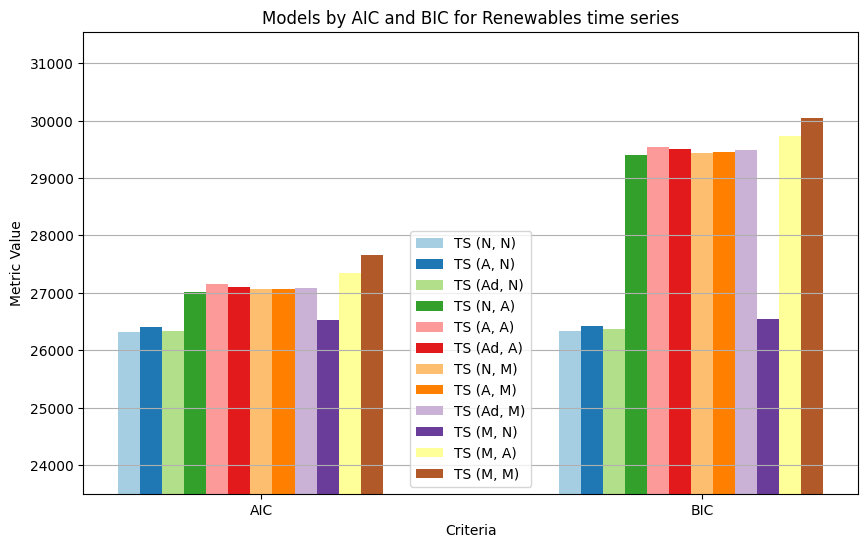

In [9]:
# Extract values for plotting
metrics = ['AIC', 'BIC']
values = [renewables_aic_values, renewables_bic_values]

# Prepare data for the bar chart
x_labels = metrics
bar_width = 0.05
x = np.arange(len(x_labels))

# Plot the bar chart
plt.figure(figsize=(10, 6))
for i in range(len(renewables_aic_values)):
    # Extract the values for the current model across metrics
    current_values = [values[j][i] for j in range(len(metrics))]
    plt.bar(x + i * bar_width, current_values, width=bar_width, label=f"{renewables_types[i]}")

# Add labels and title
plt.xticks(x + (len(renewables_aic_values) / 2) * bar_width, x_labels)
plt.xlabel("Criteria")
plt.ylabel("Metric Value")
plt.title("Models by AIC and BIC for Renewables time series")
plt.ylim(23500,)
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.show()

### Best Model by Information Criteria

While selecting the best model based solely on the lowest AIC value is a common approach, it is a simplification. Both AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) provide measures of model quality, but they penalize model complexity differently. Ideally, both criteria should be considered together when comparing models. The best model is typically the one that achieves a good balance between fit and simplicity, as indicated by low values for both AIC and BIC.

In [10]:
# Find the model with the best (lowest) AIC value
renewables_index_of_min = renewables_aic_values.index(min(renewables_aic_values))
print(f"Type with best R squared: {renewables_types[renewables_index_of_min]}")
print(f"R squared of '{renewables_types[renewables_index_of_min]}': {round(renewables_r_squared[renewables_index_of_min] * 100, 3)}%")

Type with best R squared: TS (N, N)
R squared of 'TS (N, N)': -23.844%


### Best Model by R-squared

Identify the model with the highest R-squared value (best explanatory power).

In [11]:
# Find the model with the best (highest) R-squared value
renewables_index_of_max = renewables_r_squared.index(max(renewables_r_squared))
print(f"Type with best R squared: {renewables_types[renewables_index_of_max]}")
print(f"R squared of '{renewables_types[renewables_index_of_max]}': {round(renewables_r_squared[renewables_index_of_max] * 100, 3)}%")

Type with best R squared: TS (A, A)
R squared of 'TS (A, A)': 43.04%


Choosing a model with the lowest complexity (i.e., the simplest model) does not guarantee a good fit to the data. While simpler models are less likely to overfit and are easier to interpret, they may fail to capture important patterns, trends, or seasonality present in the time series. As a result, a model that is too simple can underfit, leading to poor predictive performance and low explanatory power. It is important to balance model simplicity with the ability to accurately represent the underlying data, using both information criteria (like AIC/BIC) and performance metrics (such as R-squared or MAPE) to guide model selection.

## Analysis of Non-Renewable Energy Models

### Information Criteria Comparison

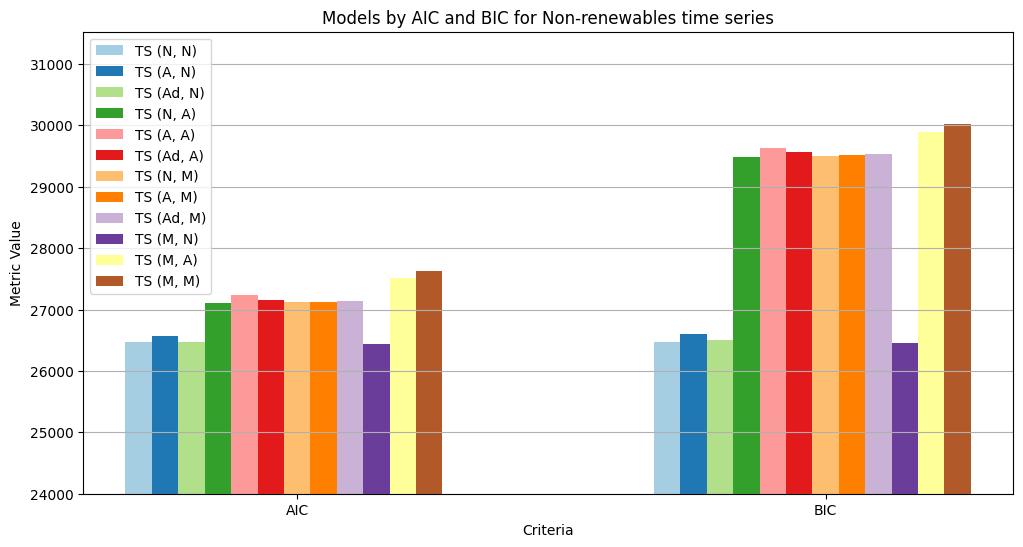

In [12]:
# Extract values for plotting
metrics = ['AIC', 'BIC']
values = [non_renewables_aic_values, non_renewables_bic_values]

# Prepare data for the bar chart
x_labels = metrics
bar_width = 0.05
x = np.arange(len(x_labels))

# Plot the bar chart
plt.figure(figsize=(12, 6))
for i in range(len(non_renewables_aic_values)):
    # Extract the values for the current model across metrics
    current_values = [values[j][i] for j in range(len(metrics))]
    plt.bar(x + i * bar_width, current_values, width=bar_width, label=f"{non_renewables_types[i]}")

# Add labels and title
plt.xticks(x + (len(non_renewables_aic_values) / 2) * bar_width, x_labels)
plt.xlabel("Criteria")
plt.ylabel("Metric Value")
plt.title("Models by AIC and BIC for Non-renewables time series")
plt.ylim(24000,)
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.show()

### Best Model by Information Criteria

In [13]:
# Find the model with the best (lowest) AIC value
non_renewables_index_of_min = non_renewables_aic_values.index(min(non_renewables_aic_values))
print(f"Type with best R squared: {non_renewables_types[non_renewables_index_of_min]}")
print(f"R squared of '{non_renewables_types[non_renewables_index_of_min]}': {round(non_renewables_r_squared[non_renewables_index_of_min] * 100, 3)}%")

Type with best R squared: TS (M, N)
R squared of 'TS (M, N)': -4346655.33%


### Best Model by R-squared

Identify the model with the highest R-squared value (best explanatory power).

In [14]:
# Find the model with the best (highest) R-squared value
non_renewables_index_of_max = non_renewables_r_squared.index(max(non_renewables_r_squared))
print(f"Type with best R squared: {non_renewables_types[non_renewables_index_of_max]}")
print(f"R squared of '{non_renewables_types[non_renewables_index_of_max]}': {round(non_renewables_r_squared[non_renewables_index_of_max] * 100, 3)}%")

Type with best R squared: TS (A, M)
R squared of 'TS (A, M)': -36.328%


Even though the R-squared values for all models are relatively low—indicating that none of the exponential smoothing configurations explain a large proportion of the variance in the test data, it is important to note that the simplest model (with multiplicative trend and no seasonality) actually performed worse in terms of fit. This is reflected by its lower R-squared and higher error metrics compared to more complex models that include additive trend and multiplicative seasonality components.

This outcome highlights that reducing model complexity does not always lead to better generalization or fit, especially when the underlying data exhibits patterns (such as trends or seasonality) that simple models cannot capture. In this case, even though the overall explanatory power is limited, models with additional components (like additive trend or seasonality) still provide a better fit to the data than the most basic configuration. Thus, balancing simplicity and the ability to model real data characteristics is crucial for effective forecasting.

## Generating Forecasts with the Best Models

The best performing models wiil be used to generate forecasts for both renewable and non-renewable energy production.

### Set Visualization Style

The colour palette will be for our forecast visualizations.

In [15]:
# Set a different colour palette for forecast visualizations
sns.set_palette("Set2")

### Renewable Energy

#### Forecast by Model with highest R-squared

In [16]:
# Get the best exponential smoothing configuration for renewables based on R-squared performance
renewables_es_type = exponential_smoothing_types[renewables_types[renewables_index_of_max]]

model = ExponentialSmoothing(renewables_df_train.values.squeeze(), trend=renewables_es_type[0], damped_trend=renewables_es_type[1], seasonal=renewables_es_type[2], seasonal_periods=366)
fitted_model = model.fit()
renewables_forecast = fitted_model.forecast(steps=len(renewables_df_test))

#### Visualize Forecast with highest R-squared

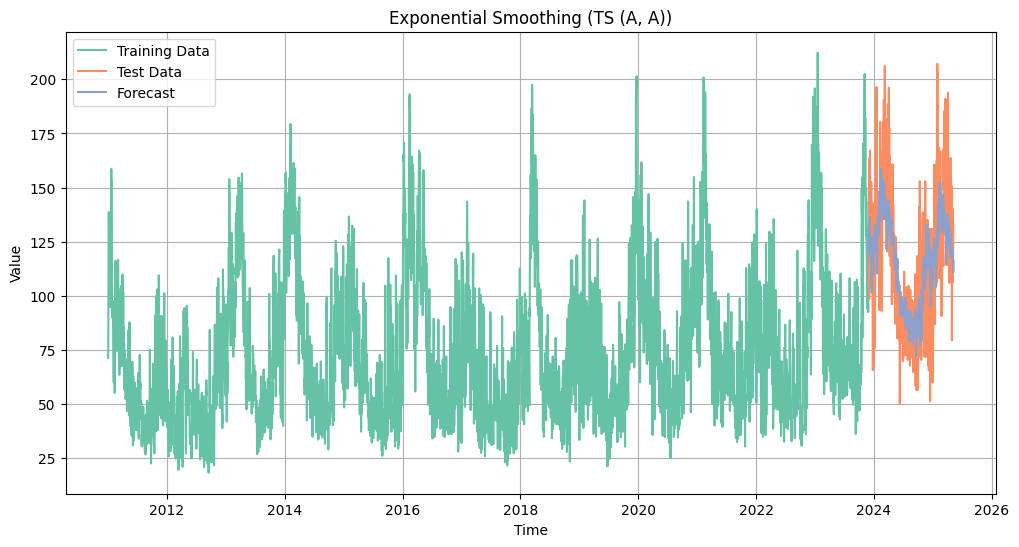

In [17]:
# Plot training data, test data, and forecast for renewable energy
plt.figure(figsize=(12, 6))
plt.plot(renewables_df_train.index, renewables_df_train, label='Training Data')
plt.plot(renewables_df_test.index, renewables_df_test, label='Test Data')
plt.plot(renewables_df_test.index, renewables_forecast, label='Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Exponential Smoothing ({renewables_types[renewables_index_of_max]})')
plt.legend()
plt.grid(True)
plt.show()

#### Forecast by Model with lowest Complexity

In [18]:
# Get the best exponential smoothing configuration for renewables based on R-squared performance
renewables_es_type = exponential_smoothing_types[renewables_types[renewables_index_of_min]]

model = ExponentialSmoothing(renewables_df_train.values.squeeze(), trend=renewables_es_type[0], damped_trend=renewables_es_type[1], seasonal=renewables_es_type[2], seasonal_periods=366)
fitted_model = model.fit()
renewables_forecast = fitted_model.forecast(steps=len(renewables_df_test))

#### Visualize Forecast with lowest Complexity

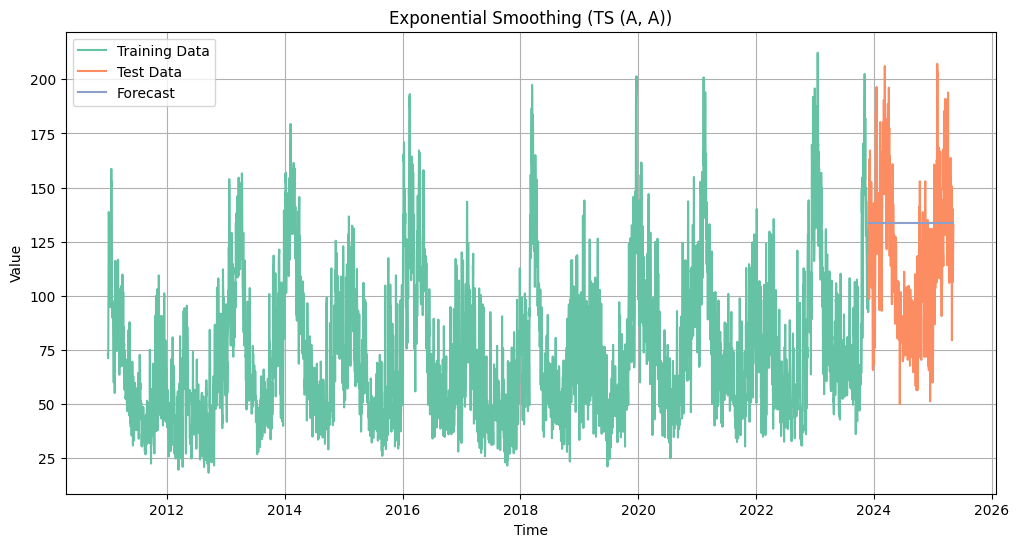

In [19]:
# Plot training data, test data, and forecast for renewable energy
plt.figure(figsize=(12, 6))
plt.plot(renewables_df_train.index, renewables_df_train, label='Training Data')
plt.plot(renewables_df_test.index, renewables_df_test, label='Test Data')
plt.plot(renewables_df_test.index, renewables_forecast, label='Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Exponential Smoothing ({renewables_types[renewables_index_of_max]})')
plt.legend()
plt.grid(True)
plt.show()

While information criteria such as AIC and BIC are useful for comparing model quality and penalizing complexity, the graphs above show that the models with the lowest AIC/BIC do not necessarily provide the best fit to the data. In this analysis, the models selected by minimum information criteria often have poor R-squared values and higher forecast errors, indicating that they fail to capture important patterns in the time series. Therefore, relying solely on information criteria can lead to the selection of models that do not generalize well or explain the variance in the data. It is essential to consider both information criteria and performance metrics (like R-squared and MAPE) when choosing the most appropriate forecasting model.

### Non-Renewable Energy Forecast

#### Forecast with highest R-squared

In [20]:
# Get the best exponential smoothing configuration for non-renewables
non_renewables_es_type = exponential_smoothing_types[non_renewables_types[non_renewables_index_of_max]]

# Create and fit the model with the best configuration
model = ExponentialSmoothing(non_renewables_df_train.values.squeeze(), trend=non_renewables_es_type[0], damped_trend=non_renewables_es_type[1], seasonal=non_renewables_es_type[2], seasonal_periods=366)
fitted_model = model.fit()

# Generate forecasts for the test period
non_renewables_forecast = fitted_model.forecast(steps=len(non_renewables_df_test))

#### Visualize Forecast with highest R-squared

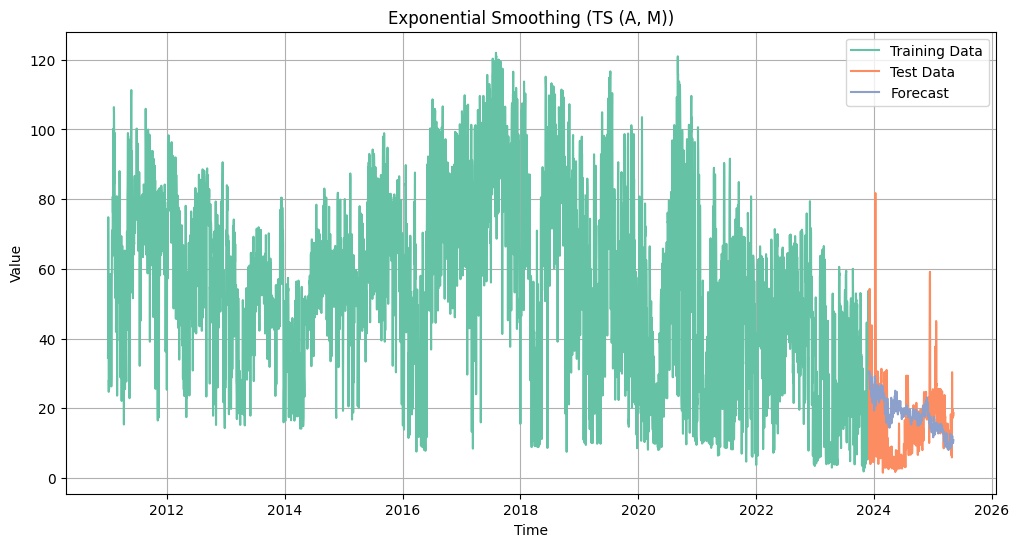

In [21]:
# Plot training data, test data, and forecast for non-renewable energy
plt.figure(figsize=(12, 6))
plt.plot(non_renewables_df_train.index, non_renewables_df_train, label='Training Data')
plt.plot(non_renewables_df_test.index, non_renewables_df_test, label='Test Data')
plt.plot(non_renewables_df_test.index, non_renewables_forecast, label='Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Exponential Smoothing ({non_renewables_types[non_renewables_index_of_max]})')
plt.legend()
plt.grid(True)
plt.show()

#### Forecast with lowest Complexity

In [22]:
# Get the best exponential smoothing configuration for non-renewables
non_renewables_es_type = exponential_smoothing_types[non_renewables_types[non_renewables_index_of_min]]

# Create and fit the model with the best configuration
model = ExponentialSmoothing(non_renewables_df_train.values.squeeze(), trend=non_renewables_es_type[0], damped_trend=non_renewables_es_type[1], seasonal=non_renewables_es_type[2], seasonal_periods=366)
fitted_model = model.fit()

# Generate forecasts for the test period
non_renewables_forecast = fitted_model.forecast(steps=len(non_renewables_df_test))

/Users/xoutoz/workspace/master/ASTP/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


#### Visualize Forecast with lowest Complexity

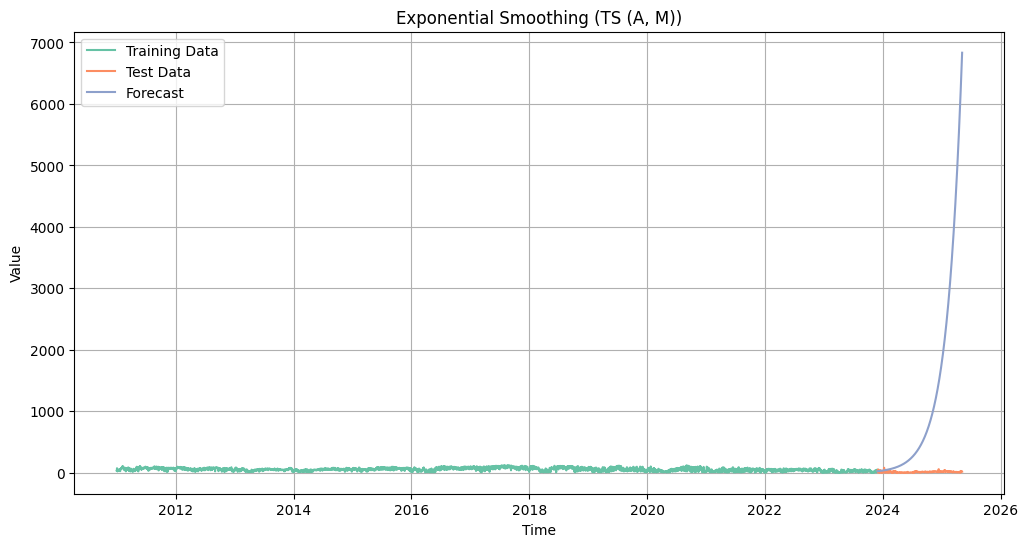

In [23]:
# Plot training data, test data, and forecast for non-renewable energy
plt.figure(figsize=(12, 6))
plt.plot(non_renewables_df_train.index, non_renewables_df_train, label='Training Data')
plt.plot(non_renewables_df_test.index, non_renewables_df_test, label='Test Data')
plt.plot(non_renewables_df_test.index, non_renewables_forecast, label='Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Exponential Smoothing ({non_renewables_types[non_renewables_index_of_max]})')
plt.legend()
plt.grid(True)
plt.show()

Comparing the two graphs above, it is clear that the less complex model fails to capture any meaningful pattern in the data—its forecast remains essentially a exponential function and does not follow the actual trend or seasonality of the time series. This indicates a complete lack of fit. In contrast, the more complex model is able to learn and replicate some of the underlying patterns present in the data, like the trend. However, even this model does not achieve a particularly strong fit, as evidenced by the gap between the forecast and the actual test data. This highlights that while increasing model complexity can help capture more structure, it does not always guarantee a good fit, especially if the model is still not sufficiently expressive or if the data exhibits complex dynamics.